<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [41]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats

import keras.backend as K
from keras.applications.vgg19 import VGG19

## Import dataset BSD

In [42]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))


print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

300


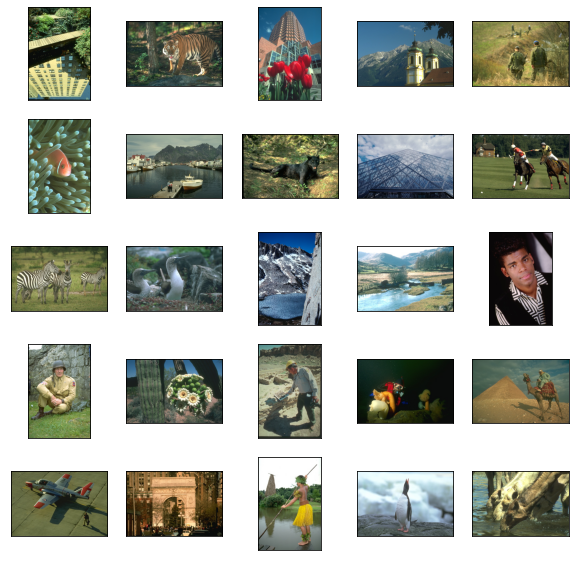

In [43]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per salvare le immagini in due array


*   Array di matrici RGB 
*   Array di oggetti immagine

Eseguiamo il crop delle immagini

In [44]:
n=256

test_as_img = []
test_as_arr = []
for i in range(image_count_test):
  image=cv2.imread(str(test_temp[i]))
  image=image[0:n,0:n,0:3]
  test_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image - 127.5) / 127.5
  test_as_arr.append(image)
  
train_as_img=[]
train_as_arr=[]
for i in range(image_count_train):
  image=cv2.imread(str(train_temp[i]))
  image=image[0:n,0:n,0:3]
  train_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image - 127.5) / 127.5
  train_as_arr.append(image)

image_size=[n,n,3]
print(image_size)


[256, 256, 3]


In [45]:
#plt.figure(figsize=(10,10))
#for i in range(25):
 #   plt.subplot(5,5,i+1)
 #   plt.xticks([])
 #   plt.yticks([])
 #   plt.grid(False)
  #  plt.imshow(test_as_arr[i], cmap=plt.cm.binary)
   
#plt.show()

## Adding Noise

In [46]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [47]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.005, 0.02
    sigma = 0.003

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return
  # random_noise returns [0,1] value
  # normalize images between [-1, 1]
  
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img_rgb = (noise_img_rgb - 127.5) / 127.5 ; 
  return noise_img_rgb 

## Generatore - Discriminatore 

In [48]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [49]:
image_shape=image_size
print(image_size)

[256, 256, 3]


In [50]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [51]:
@tf.function
def preproces_vgg(x_):
    # scale from [-1,1] to [0, 255]
    x_ += 1.
    x_ *= 127.5

    # RGB -> BGR
    x_ = x_[..., ::-1]
    

    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x_ = K.bias_add(x_, K.cast(_IMAGENET_MEAN, K.dtype(x_)))

    return x_
  

In [52]:

def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=(256,256,3), 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False

    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)

    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))

    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

In [53]:
# Loss building blocks

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse = keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
_vgg = None


def _get_vgg19():
    if _vgg is not None:
        return _vgg
    else:
        return keras.applications.VGG19(include_top=False, weights='imagenet')


def vgg19_loss(block_idx, conv_idx):
    mean = tf.constant([103.939, 116.779, 123.68])
    vgg = _get_vgg19()
    vgg_features = keras.models.Model(
        vgg.input,
        vgg.get_layer(f'block{block_idx}_conv{conv_idx}').output)

    def loss(y_true, y_pred):
        features_true = vgg_features((y_true * 255) - mean) / 12.75
        features_pred = vgg_features((y_pred * 255) - mean) / 12.75
        return mse(features_true, features_pred)

    return loss

In [54]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  # e1 = define_encoder_block(in_image, 64, batchnorm=False)
  # e2 = define_encoder_block(e1, 128)
  # e3 = define_encoder_block(e2, 256)
  # e4 = define_encoder_block(e3, 512)
  # e6 = define_encoder_block(e4, 512)

  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # d1 = decoder_block(b, e6, 512)
  # d2 = decoder_block(d1, e5, 512)
  # d3 = decoder_block(d1, e4, 512)
  # d4 = decoder_block(d3, e3, 256, dropout=False)
  # d5 = decoder_block(d4, e2, 128, dropout=False)
  # d6 = decoder_block(d5, e1, 64, dropout=False)


  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)

  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image, name='Generator')
  
  return model

In [55]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C512
	# d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)
	# second last output layer

	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)

	# patch output
	d = Flatten()(d)
	d = Dense(512, activation=None)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output_discriminator = Dense(1, activation='sigmoid')(d)

	# define model
	model = Model(in_image, output_discriminator, name='Discriminator')
	# compile model
	opt = Adam(learning_rate=1e-4, beta_1=0.9)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"], loss_weights=[1])
	return model

In [56]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	#for layer in d_model.layers:
	#	if not isinstance(layer, BatchNormalization):
	#		layer.trainable = False
	# define the source image
	d_model.trainable = False
	in_src = Input(shape=image_shape)
	print(in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	############
	dis_out = d_model(gen_out)
	#dis_out = d_model(in_src)
	#############
	# src image as input, generated image and classification output
	model = Model(in_src, [gen_out, dis_out], name='GAN')
	#model = Model(in_src, dis_out, name='GAN')
	# compile model
	opt = Adam(learning_rate=1e-4, beta_1=0.9)
	#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])
	model.compile(loss=['mse', 'binary_crossentropy'], optimizer=opt, loss_weights=[1., 1e-3])
	return model


In [57]:
# define the models
d_model = define_discriminator(image_size)
g_model = define_generator(image_size)


In [58]:
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                     

In [59]:
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 64  3136        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_16[0][0]']              
                                )                                                         

In [60]:
# define the composite model
gan_model = define_gan(g_model, d_model, image_size)

(None, 256, 256, 3)


In [61]:
#keras.utils.plot_model(g_model, "Generator.jpg", show_shapes=True)

In [62]:
#gan_model.summary()

## Training

In [63]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [64]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, image_count_train, n_samples)
  ix = np.array(ix).astype(int)
  X = np.zeros((n_samples, 256, 256, 3))
  # retrieve selected images
  for i in range(n_samples):
    X[i]=train_as_arr[ix[i]]
  X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2],X.shape[3]))
  
  # generate 'real' class labels (1)
  y = np.ones(n_samples)
  #y = np.ones((n_samples, patch_shape, 1))
  return X , y, ix
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, ix, n_samples, noisy_samples):
  # generate fake instance
  #samples = np.zeros((n_samples, 256, 256, 3))
  #for i in range(n_samples):
  #  samples[i]=apply_noise_to_image(train_as_img[ix[i]])

  #noisy_samples = np.reshape(noisy_samples, (noisy_samples.shape[0], noisy_samples.shape[1], noisy_samples.shape[2], noisy_samples.shape[3]))
  #print("Samples:")
  #print(n_samples)
  #print(noisy_samples.shape)
  
  X = g_model.predict(noisy_samples)
  #print("FakeSamples:")
  #print(X.shape)
  # create 'fake' class labels (0)
  y = np.zeros(n_samples)
  return X , y

In [75]:
# utility function to plot some figures
def plot_figures(x, n, figsize=(20,20), dpi=20):
  plt.figure(figsize=figsize)
  if n == 1:
    img=x[:,:,:]
    # rescale for visualization purposes
    img = ((img*127.5) + 127.5).astype("uint8")
    plt.imshow(img)
  else:
    for i in range(n):

      plt.subplot(1,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img=x[i,:,:,:]
      # rescale for visualization purposes
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)

  plt.show()

In [66]:
# TODO: va nel for
		# summarize performance
#		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
#		if (i+1) % (bat_per_epo * 10) == 0:
#			summarize_performance(i, g_model, dataset)

In [67]:
def gen_benchmark_images(img, index):
  noise_choises=["gaussian", "s&p", "speckle"];

  if noise_choises[index]=="gaussian":
    mean=0;
    upper = 0.03
    lower=0.005
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=lower)

  elif noise_choises[index]=="s&p":
    upper = 0.07
    lower=0.02
    noise_img = random_noise(img, mode='s&p', amount=lower)

  elif noise_choises[index]=="speckle":
    upper = 0.02
    lower=0.005
    noise_img = random_noise(img, mode='speckle', var=lower)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img_rgb = (noise_img_rgb - 127.5) / 127.5 
  return noise_img_rgb #random_noise returns [0,1] value

In [69]:

def train(d_model, g_model, gan_model, n_epochs=100, n_batch=1):
  # store benchmark images per epoch
  benchmarkImages=np.zeros((3, 256, 256, 3))
  benchmarkImages[0]=gen_benchmark_images(train_as_img[0], 0)
  benchmarkImages[1]=gen_benchmark_images(train_as_img[0], 1)
  benchmarkImages[2]=gen_benchmark_images(train_as_img[0], 2)
  benchmarkImages = np.reshape(benchmarkImages, (benchmarkImages.shape[0], benchmarkImages.shape[1], benchmarkImages.shape[2], benchmarkImages.shape[3]))
  # define collections of metrics
  history={}
  history['G_loss'] = []
  history['D_loss_true'] = []
  history['D_loss_fake'] = []
  accuracy = {}
  accuracy['Acc_true'] = []
  accuracy['Acc_fake'] = []
  # calculate the number of batches per training epoch
  
  # calculate the number of training iterations
  # manually enumerate epochs
  for epoch in range(n_epochs):
    #print("Epoch "+ str(epoch))
    image_per_epoch = int(image_count_train / n_batch)
    # select a batch of real and fake samples 
    X_real, y_real, ix = generate_real_samples(train_as_arr, image_per_epoch)
    
    X_noisy = np.zeros((image_per_epoch, 256, 256, 3))
    for j in range(image_per_epoch):
      img=train_as_img[ix[j]]
      X_noisy[j]=apply_noise_to_image(img)
    X_noisy = np.reshape(X_noisy, (X_noisy.shape[0], X_noisy.shape[1],X_noisy.shape[2],X_noisy.shape[3]))
    
    for i in range(n_batch):
      #Generate noisy images
      #print("Batch "+ str(i))

      #####################
      # train discriminator
      d_model.trainable = True
      # generate a batch of fake samples
      X_gen, y_fake = generate_fake_samples(g_model, ix, image_per_epoch, X_noisy)
      # update discriminator for original samples
      d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
      history['D_loss_true'].append(d_loss1)
      accuracy['Acc_true'].append(d_acc1)
      # update discriminator for noisy samples
      d_loss2, d_acc2 = d_model.train_on_batch(X_gen, y_fake)
      history['D_loss_fake'].append(d_loss2)
      accuracy['Acc_fake'].append(d_acc2)
      
      ########################
      # train generator
      d_model.trainable = False
      fake_labels = [1] * image_per_epoch
      fake_labels = np.reshape(fake_labels, (-1,))
      g_loss, g_mse, g_bce = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])
      history['G_loss'].append(g_loss)
   
    print("epoch " + str(epoch) + ": discriminator loss true " + str(d_loss1)+  " ( "  + str(d_acc1) + " ) - discriminator loss fake " + str(d_loss2) + " ( "  + str(d_acc2) + " )") 
    print("generator loss " + str(g_loss) + " ("  + str(g_mse) + " + "  + str(g_bce) + ")")

    # it is important to regularly visualize the output
    images= np.zeros((3, 256, 256, 3))
    images=g_model.predict(benchmarkImages)
    if (epoch % 5) == 0:
      plot_figures(images,3, figsize=(20,20), dpi=20)
    return history, accuracy
    

epoch 0: discriminator loss true 0.0004975831252522767 ( 1.0 ) - discriminator loss fake 0.0004299758584238589 ( 1.0 )
generator loss 0.05602668598294258 (0.050196997821331024 + 5.829683303833008)


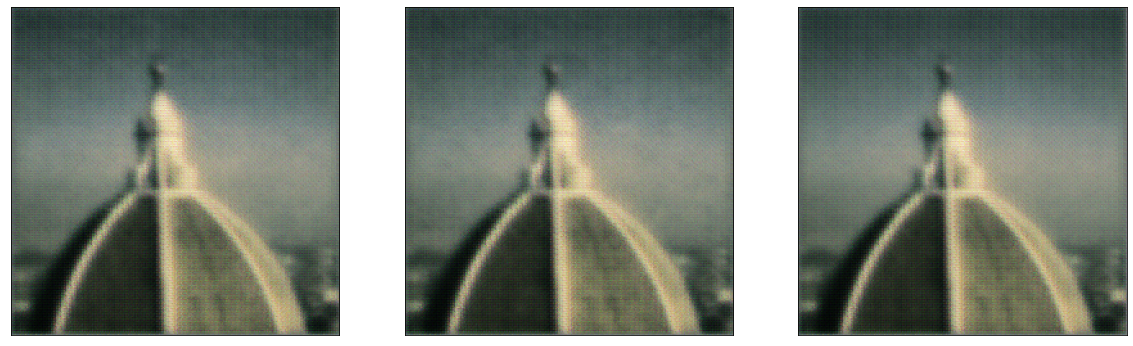

epoch 1: discriminator loss true 0.0024452232755720615 ( 1.0 ) - discriminator loss fake 0.002916524652391672 ( 1.0 )
generator loss 0.03157718479633331 (0.02871943637728691 + 2.8577487468719482)
epoch 2: discriminator loss true 0.0034720334224402905 ( 1.0 ) - discriminator loss fake 0.004533678293228149 ( 1.0 )
generator loss 0.02725399099290371 (0.023070544004440308 + 4.1834492683410645)
epoch 3: discriminator loss true 0.0031554121524095535 ( 1.0 ) - discriminator loss fake 0.00381045532412827 ( 1.0 )
generator loss 0.01933012157678604 (0.01557509321719408 + 3.7550292015075684)
epoch 4: discriminator loss true 0.0017466619610786438 ( 1.0 ) - discriminator loss fake 0.0030168627854436636 ( 1.0 )
generator loss 0.022161010652780533 (0.01844773069024086 + 3.7132792472839355)
epoch 5: discriminator loss true 0.0031198556534945965 ( 1.0 ) - discriminator loss fake 0.005237038247287273 ( 1.0 )
generator loss 0.023139875382184982 (0.01855248026549816 + 4.587393760681152)


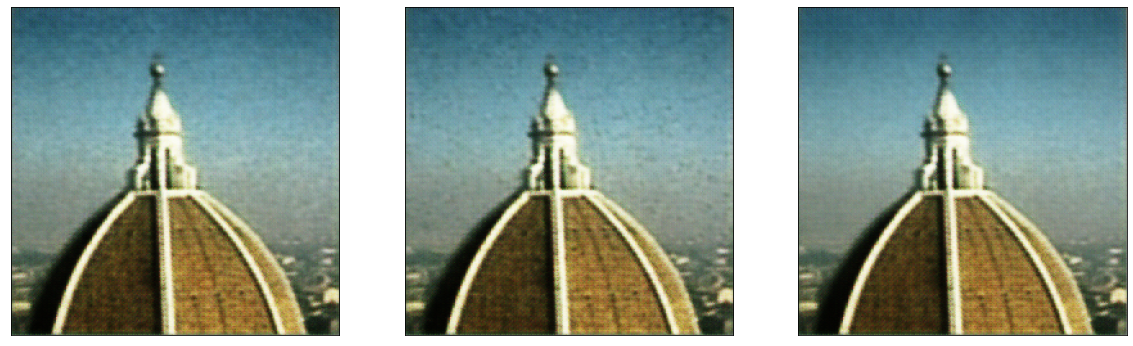

epoch 6: discriminator loss true 0.011544677428901196 ( 1.0 ) - discriminator loss fake 0.012487470172345638 ( 1.0 )
generator loss 0.02148984745144844 (0.018293416127562523 + 3.1964309215545654)
epoch 7: discriminator loss true 0.028012698516249657 ( 1.0 ) - discriminator loss fake 0.03289859741926193 ( 1.0 )
generator loss 0.022165805101394653 (0.0194725189357996 + 2.693286418914795)
epoch 8: discriminator loss true 0.023026257753372192 ( 1.0 ) - discriminator loss fake 0.02892146073281765 ( 1.0 )
generator loss 0.022445421665906906 (0.019546490162611008 + 2.898930549621582)
epoch 9: discriminator loss true 0.039689090102910995 ( 1.0 ) - discriminator loss fake 0.05576346442103386 ( 1.0 )
generator loss 0.014445856213569641 (0.012894967570900917 + 1.5508884191513062)
epoch 10: discriminator loss true 0.01813260279595852 ( 1.0 ) - discriminator loss fake 0.1544072926044464 ( 1.0 )
generator loss 0.01715877279639244 (0.014025521464645863 + 3.1332504749298096)


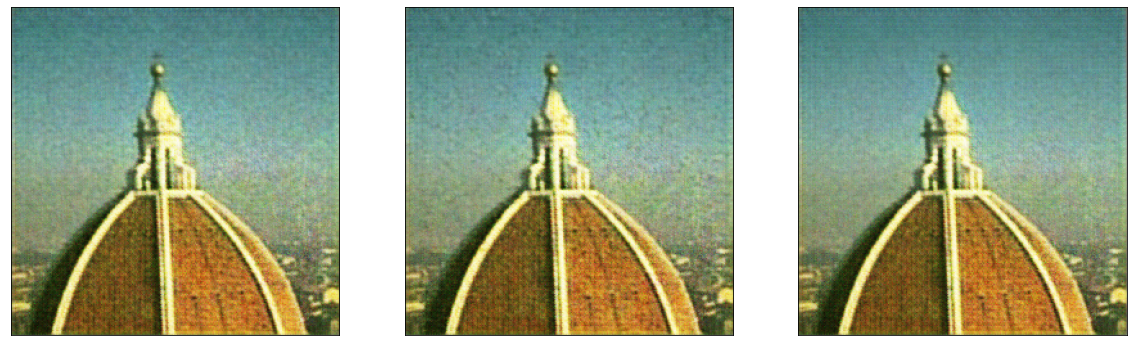

epoch 11: discriminator loss true 0.14435698091983795 ( 1.0 ) - discriminator loss fake 0.14860601723194122 ( 1.0 )
generator loss 0.024831518530845642 (0.020016159862279892 + 4.815358638763428)
epoch 12: discriminator loss true 0.17960382997989655 ( 1.0 ) - discriminator loss fake 0.19261454045772552 ( 1.0 )
generator loss 0.01486058346927166 (0.010486957617104053 + 4.373625755310059)
epoch 13: discriminator loss true 0.18960729241371155 ( 1.0 ) - discriminator loss fake 0.17969384789466858 ( 1.0 )
generator loss 0.011795522645115852 (0.009898265823721886 + 1.8972564935684204)
epoch 14: discriminator loss true 0.2852969467639923 ( 1.0 ) - discriminator loss fake 0.08233597874641418 ( 1.0 )
generator loss 0.015152372419834137 (0.012087760493159294 + 3.0646114349365234)
epoch 15: discriminator loss true 0.08400171995162964 ( 1.0 ) - discriminator loss fake 0.12936455011367798 ( 1.0 )
generator loss 0.018899094313383102 (0.010258931666612625 + 8.640162467956543)


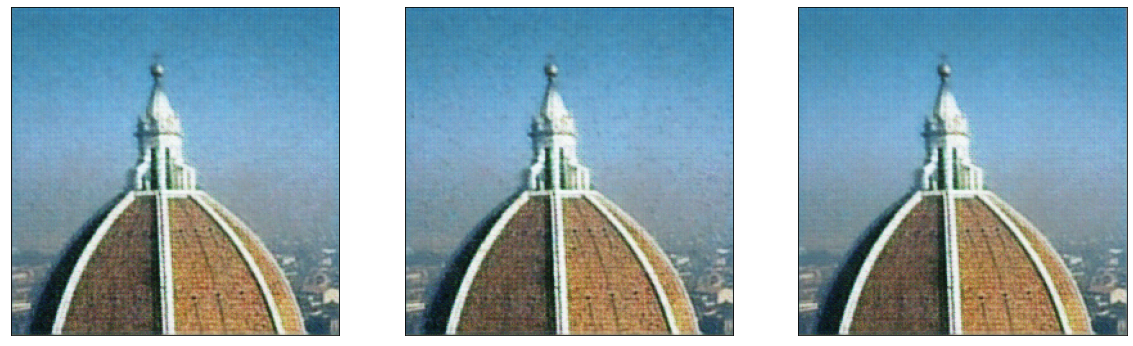

epoch 16: discriminator loss true 0.04754478111863136 ( 1.0 ) - discriminator loss fake 0.05043172091245651 ( 1.0 )
generator loss 0.013480961322784424 (0.011259329505264759 + 2.2216315269470215)
epoch 17: discriminator loss true 0.04211313650012016 ( 1.0 ) - discriminator loss fake 0.043788425624370575 ( 1.0 )
generator loss 0.01044785138219595 (0.00925715547055006 + 1.1906957626342773)
epoch 18: discriminator loss true 0.037488192319869995 ( 1.0 ) - discriminator loss fake 0.04182131960988045 ( 1.0 )
generator loss 0.008132310584187508 (0.006847516633570194 + 1.284793734550476)
epoch 19: discriminator loss true 0.029395367950201035 ( 1.0 ) - discriminator loss fake 0.033200934529304504 ( 1.0 )
generator loss 0.010015729814767838 (0.00916309468448162 + 0.852634608745575)
epoch 20: discriminator loss true 0.164009228348732 ( 1.0 ) - discriminator loss fake 0.14050200581550598 ( 1.0 )
generator loss 0.015324445441365242 (0.013773277401924133 + 1.5511672496795654)


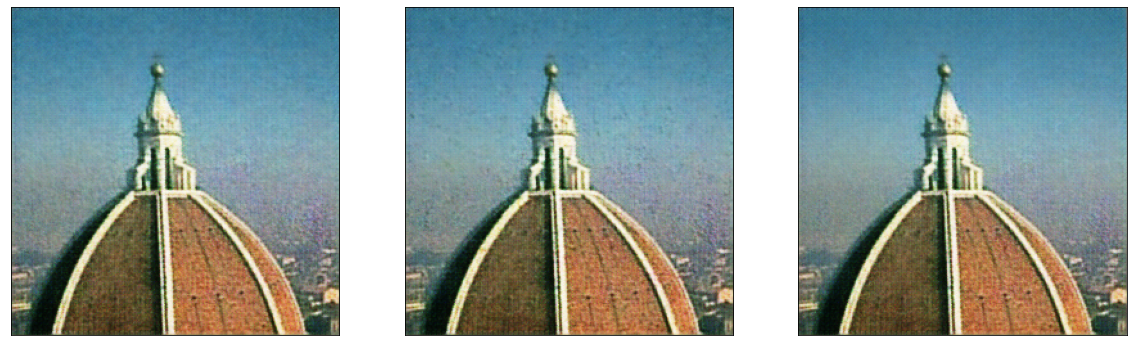

epoch 21: discriminator loss true 0.1330346167087555 ( 1.0 ) - discriminator loss fake 0.14328114688396454 ( 1.0 )
generator loss 0.011525163426995277 (0.009966889396309853 + 1.5582740306854248)
epoch 22: discriminator loss true 0.06887131929397583 ( 1.0 ) - discriminator loss fake 0.06772681325674057 ( 1.0 )
generator loss 0.010290132835507393 (0.00973669532686472 + 0.5534378886222839)
epoch 23: discriminator loss true 0.015584046021103859 ( 1.0 ) - discriminator loss fake 0.014794033952057362 ( 1.0 )
generator loss 0.0045464299619197845 (0.00400988245382905 + 0.5365473628044128)
epoch 24: discriminator loss true 0.09055817127227783 ( 1.0 ) - discriminator loss fake 0.04646407440304756 ( 1.0 )
generator loss 0.011524537578225136 (0.009869555942714214 + 1.654981255531311)
epoch 25: discriminator loss true 0.03281407803297043 ( 1.0 ) - discriminator loss fake 0.04287232086062431 ( 1.0 )
generator loss 0.007881399244070053 (0.007362891919910908 + 0.5185068845748901)


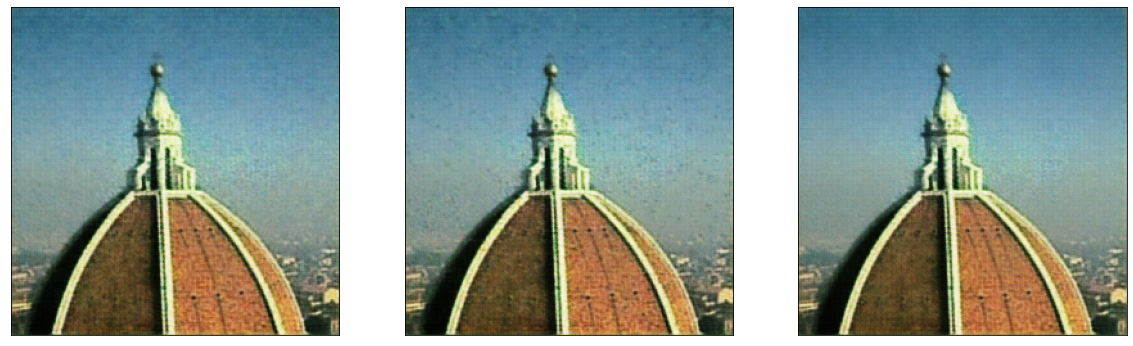

epoch 26: discriminator loss true 0.023758430033922195 ( 1.0 ) - discriminator loss fake 0.028748858720064163 ( 1.0 )
generator loss 0.009381992742419243 (0.00905795581638813 + 0.3240368962287903)
epoch 27: discriminator loss true 0.04025863856077194 ( 1.0 ) - discriminator loss fake 0.043398864567279816 ( 1.0 )
generator loss 0.008708089590072632 (0.008308986201882362 + 0.3991036117076874)
epoch 28: discriminator loss true 0.1398443728685379 ( 1.0 ) - discriminator loss fake 0.1792992651462555 ( 1.0 )
generator loss 0.009224142879247665 (0.007967134937644005 + 1.2570081949234009)
epoch 29: discriminator loss true 0.12950794398784637 ( 1.0 ) - discriminator loss fake 0.13386639952659607 ( 1.0 )
generator loss 0.006687780376523733 (0.0058959550224244595 + 0.7918254137039185)
epoch 30: discriminator loss true 0.056182824075222015 ( 1.0 ) - discriminator loss fake 0.07079435884952545 ( 1.0 )
generator loss 0.009390966035425663 (0.008564984425902367 + 0.8259812593460083)


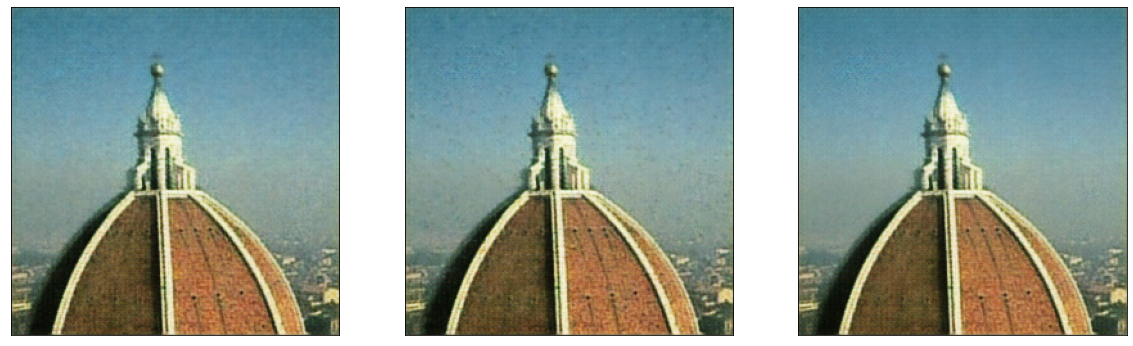

epoch 31: discriminator loss true 0.14793437719345093 ( 1.0 ) - discriminator loss fake 0.012980358675122261 ( 1.0 )
generator loss 0.016452789306640625 (0.012614781968295574 + 3.8380062580108643)
epoch 32: discriminator loss true 0.12972401082515717 ( 1.0 ) - discriminator loss fake 0.1205672025680542 ( 1.0 )
generator loss 0.010799720883369446 (0.009057753719389439 + 1.7419672012329102)
epoch 33: discriminator loss true 0.06163181737065315 ( 1.0 ) - discriminator loss fake 0.615912675857544 ( 0.800000011920929 )
generator loss 0.009474759921431541 (0.0073223174549639225 + 2.1524429321289062)
epoch 34: discriminator loss true 0.04655923694372177 ( 1.0 ) - discriminator loss fake 0.04035826027393341 ( 1.0 )
generator loss 0.01036469079554081 (0.010067601688206196 + 0.2970893979072571)
epoch 35: discriminator loss true 0.04211488366127014 ( 1.0 ) - discriminator loss fake 0.03400352969765663 ( 1.0 )
generator loss 0.00831542257219553 (0.008056474849581718 + 0.2589479684829712)


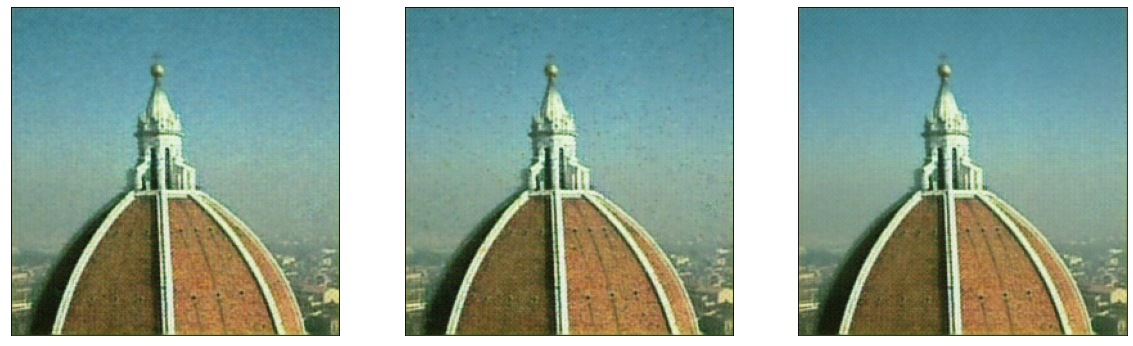

epoch 36: discriminator loss true 0.03989739716053009 ( 1.0 ) - discriminator loss fake 0.045979954302310944 ( 1.0 )
generator loss 0.00712962681427598 (0.006242291070520878 + 0.8873358964920044)
epoch 37: discriminator loss true 0.011135137639939785 ( 1.0 ) - discriminator loss fake 0.013138553127646446 ( 1.0 )
generator loss 0.007497778628021479 (0.007010090164840221 + 0.4876885414123535)
epoch 38: discriminator loss true 0.06056032329797745 ( 1.0 ) - discriminator loss fake 0.05518664792180061 ( 1.0 )
generator loss 0.011135579086840153 (0.010743552818894386 + 0.3920260965824127)
epoch 39: discriminator loss true 0.003953555133193731 ( 1.0 ) - discriminator loss fake 0.006343689747154713 ( 1.0 )
generator loss 0.007705987896770239 (0.007609551306813955 + 0.0964367687702179)
epoch 40: discriminator loss true 0.009084058925509453 ( 1.0 ) - discriminator loss fake 0.010550759732723236 ( 1.0 )
generator loss 0.009880287572741508 (0.00971303228288889 + 0.16725564002990723)


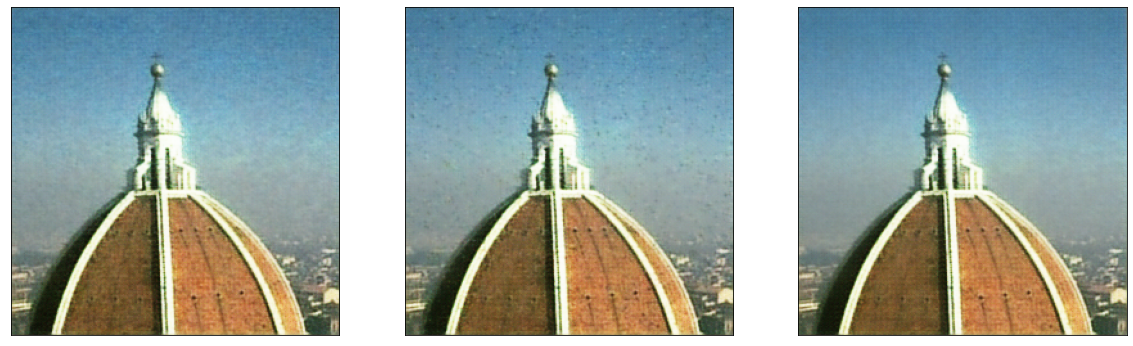

In [70]:
# train model
history, accuracy = train(d_model, g_model, gan_model, n_epochs=41, n_batch=40)

In [71]:
import pandas
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()

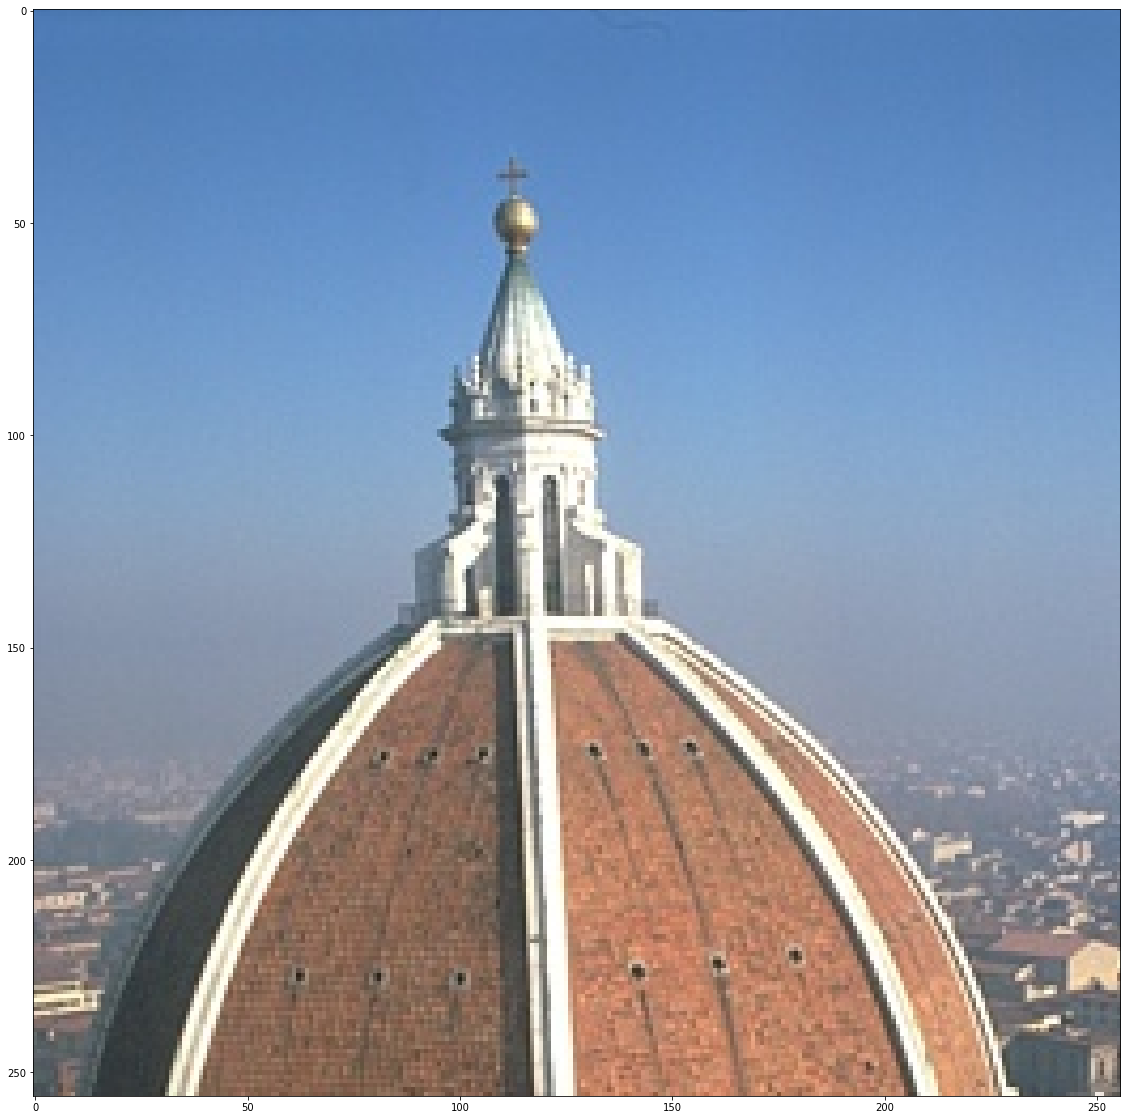

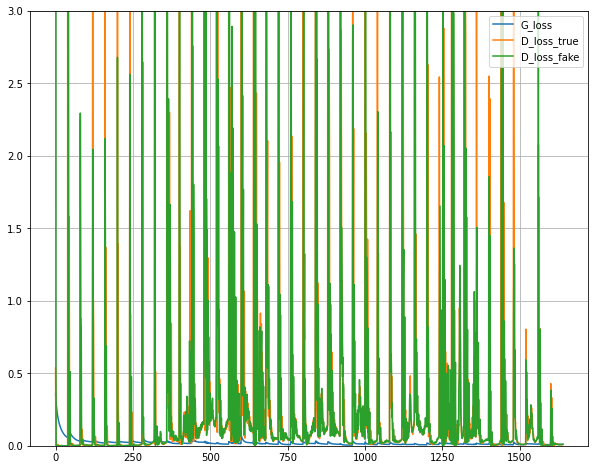

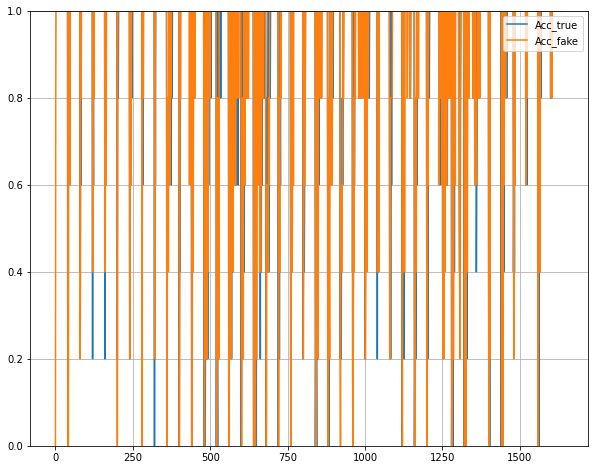

In [77]:
plot_figures(train_as_arr[0], 1)
plot_figures(train_as_arr[0], 1)

plot_losses(history, 3)
plot_losses(accuracy, 1)